In [35]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Import dataframe
from Dash.app_dataframe import df_hom

In [56]:
df_hom

,fecha,ano,dia,departamento,municipio,codigo,arma,genero,edad_grupo,cantidad,Tipo Centro Poblado,Longitud,Latitud
0,2010-01-01,2010,Viernes,ANTIOQUIA,AMAGÁ,5030000,ARMA BLANCA,MASCULINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-75.701948,6.038808
1,2010-01-01,2010,Viernes,ANTIOQUIA,MEDELLÍN (CT),5001000,ARMA BLANCA,MASCULINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-75.576002,6.248586
2,2010-01-01,2010,Viernes,ANTIOQUIA,RIONEGRO,5615000,ARMA BLANCA,MASCULINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-75.376767,6.147225
3,2010-01-01,2010,Viernes,CUNDINAMARCA,BOGOTÁ D.C. (CT),11001000,ARMA BLANCA,FEMENINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-74.106715,4.649937
4,2010-01-01,2010,Viernes,CUNDINAMARCA,BOGOTÁ D.C. (CT),11001000,ARMA BLANCA,MASCULINO,ADOLESCENTES,1,CABECERA MUNICIPAL (CM),-74.106715,4.649937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60326,2021-12-31,2021,Viernes,VALLE,CALI (CT),76001000,ARMA DE FUEGO,MASCULINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-76.521560,3.414419
60327,2021-12-31,2021,Viernes,VALLE,EL CERRITO,76248000,ARMA DE FUEGO,MASCULINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-76.311726,3.684260
60328,2021-12-31,2021,Viernes,VALLE,FLORIDA,76275000,ARMA DE FUEGO,MASCULINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-76.234503,3.323920
60329,2021-12-31,2021,Viernes,VALLE,SAN PEDRO,76670000,ARMA DE FUEGO,FEMENINO,ADULTOS,1,CABECERA MUNICIPAL (CM),-76.228540,3.994992


In [52]:
#Load dataset and reindex by date to train
timeseries_month = df_hom.groupby(['fecha'])[['cantidad','municipio']].sum().reset_index()
timeseries_month.index = timeseries_month.fecha
df = timeseries_month.resample('M').sum()
#timeseries_month

In [24]:
#Check the data
fig =px.line(df, x=df.index, y="cantidad", title='Homicides per day in Colombia')
fig.show()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

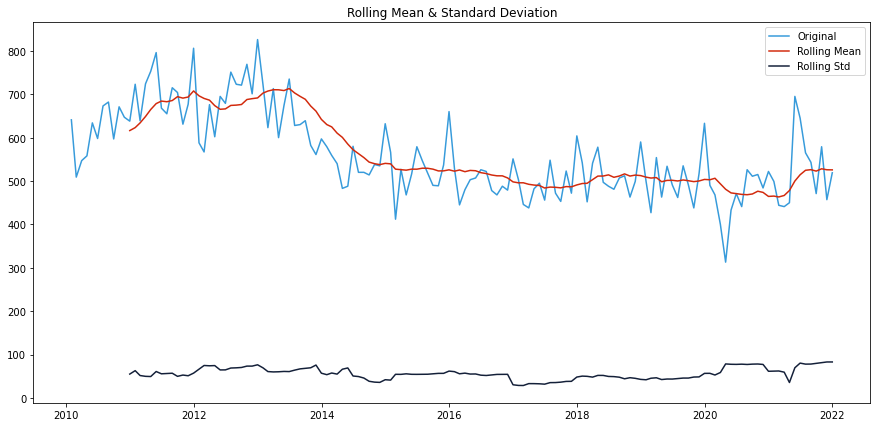

In [26]:
#Determine rolling statistics
df_p = df.copy()
df_p["rolling_avg"] = df["cantidad"].rolling(window=12).mean()
df_p["rolling_std"] = df["cantidad"].rolling(window=12).std()

#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df_p["cantidad"], color='#379BDB', label='Original')
plt.plot(df_p["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(df_p["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

In [27]:
#Perform the Dickey-Fuller test, which is able to verify whether a time series is stationary or not
def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

test_stationarity(df['cantidad'])

X is not stationary


False

In [29]:
# Transform the time series through the diff() function as many times as the time series becomes stationary
ts_diff = pd.Series(df['cantidad'])
d = 0
while test_stationarity(ts_diff) is False:
    ts_diff = ts_diff.diff().dropna()
    d = d + 1

X is not stationary
X is not stationary
X is stationary


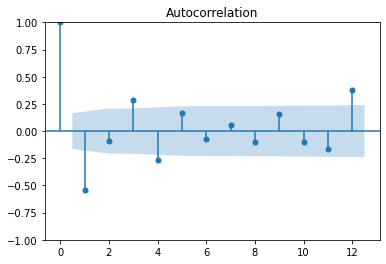

In [31]:
# Calculate the value of p (12)
plot_acf(ts_diff, lags =12)
plt.show()

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



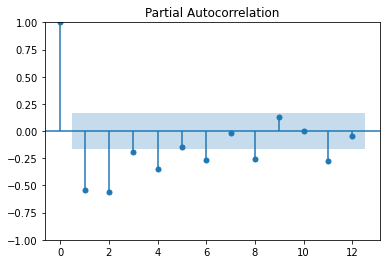

In [33]:
# Calculate the value of q (1)
plot_pacf(ts_diff, lags =12)
plt.show()

In [40]:
# Seasonal - fit stepwise auto-ARIMA to check seasonal variables and analize residuals
SARIMA_model = pm.auto_arima(df["cantidad"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

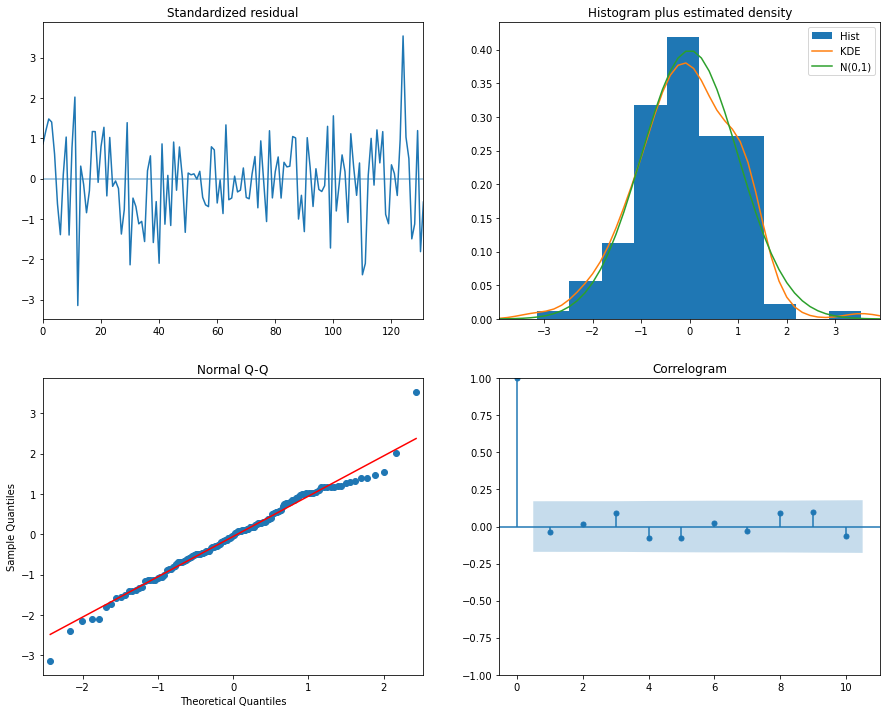

In [41]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [42]:
# Train Sarimax model
p = 11 # Is reduced to 11 because m=12 and p must be less
q = 1
model = SARIMAX(df['cantidad'], order=(p,d,q), seasonal_order=(2,0,2,12))
model_fit = model.fit(disp=1,solver='powell')
    
fcast = model_fit.get_prediction(start=1, end=len(df['cantidad']))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

with open('SARIMAX_total.pkl', 'wb') as pkl:
    pickle.dump(model_fit, pkl)

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: solver. After release 0.14, this will raise.

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



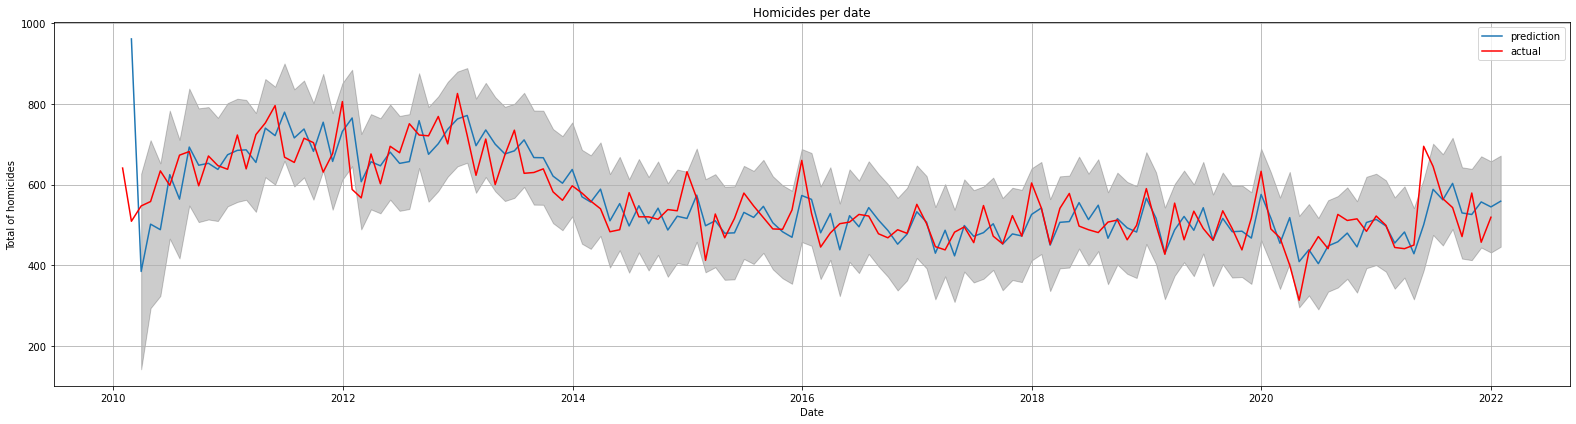

In [49]:
#Plot results
plt.figure(figsize=(22,6))
plt.plot(ts_p,label='prediction')
plt.plot(df['cantidad'],color='red',label='actual')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)
plt.title('Homicides per date')
plt.xlabel('Date')
plt.ylabel('Total of homicides')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

### Predict by cities

In [64]:
df_med = df_hom[df_hom['municipio']=='MEDELLÍN (CT)'][['fecha','cantidad']]
df_bog = df_hom[df_hom['municipio']=='BOGOTÁ D.C. (CT)'][['fecha','cantidad']]
df_cal = df_hom[df_hom['municipio']=='CALI (CT)'][['fecha','cantidad']]

In [74]:
#Load dataset and reindex by date to train
timeseries_month = df_cal.groupby(['fecha'])[['cantidad']].sum().reset_index()
timeseries_month.index = timeseries_month.fecha
df = timeseries_month.resample('M').sum()

In [76]:
# Train Sarimax model
p = 11 # Is reduced to 11 because m=12 and p must be less
q = 1
model = SARIMAX(df['cantidad'], order=(p,d,q), seasonal_order=(2,0,2,12))
model_fit = model.fit(disp=1,solver='powell')
    
fcast = model_fit.get_prediction(start=1, end=len(df['cantidad']))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

with open('SARIMAX_cal.pkl', 'wb') as pkl:
    pickle.dump(model_fit, pkl)

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning:

Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: solver. After release 0.14, this will raise.

c:\Users\beale\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



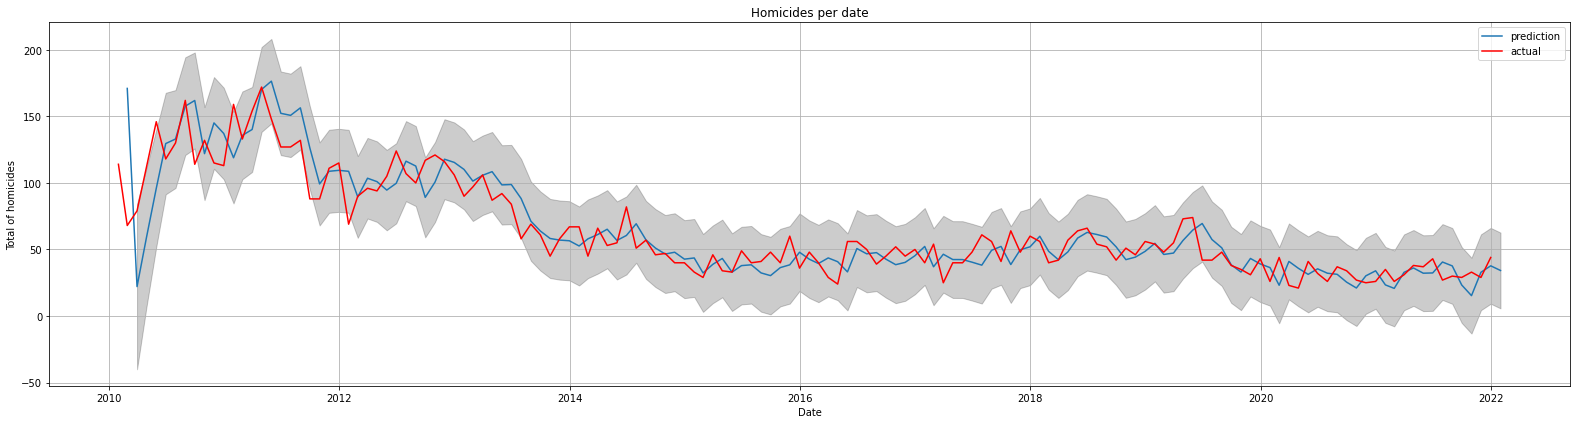

In [77]:
#Plot results
plt.figure(figsize=(22,6))
plt.plot(ts_p,label='prediction')
plt.plot(df['cantidad'],color='red',label='actual')
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)
plt.title('Homicides per date')
plt.xlabel('Date')
plt.ylabel('Total of homicides')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()